<a id=contents></a>

# Exploratory Data Analysis

[1. Data Inspection](#insp)

[2. Exploring the TF-IDF features across the dataset](#corr)

[3. Reducing dimensionality and visualising our data](#bar)

[4. Clustering with HDBSCAN](#one)

[5. Sentiment detection](#two)

[6. Using pyLDAviz](#three)

[7. ](#conc)

In this notebook, I'll be loading up the clean tweet text and metadata (nr of likes, retweets, responses) and exploring it. The goal is to explore some of the best ways of presenting and dissecting the data. To that end, I'll be:

1. Look at the TF-IDF scores of the documents and also how tf-idf varies according to the metadata. 
2. Load up sentence embeddings that we created earlier using the **SentenceTransformer** model "all-MiniLM-L6-v2". 
3. Reduce the dimensionality of those sentence vectors using UMAP and using them in tandem with the metadata to see if any clusters are visible detectable.  
4. Explore how the meta-data varies according to whether a Tweet is directed at or by ElonMusk.

I will also be using BERTTopic to extract information, however, the package has some dependency issues with the rest of my installed packages and it requires more compure than I have locally to run. Therefore, I am running BERTopic online in **GoogleColab**. 




In [18]:
%load_ext autoreload
%autoreload 2
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly_express as px
%matplotlib inline
sns.set_style("darkgrid")

from umap import UMAP
import hdbscan
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

import os
import gensim
import numpy as np 
import functions.functions as fn
import pandas as pd

import matplotlib.dates as md


<a id=insp ><a/> 

## 1. Data Inspection
    
[LINK to table of contents](#contents)

In [73]:
# vect = pd.read_csv('data/clean/features/count_vect_feats.csv', index_col=0)
df = pd.read_csv('data/clean/clean_display_data.csv', index_col=0, engine='python')

In [74]:
df.head(1)

,tweet_id,datetime,display_name,tweet_text,User_id,#likes,#retweets,#responses,language,extracted_twitter_handles,extracted_URLs,extracted_hashtags,clean_tweet_text,Before_or_after_controversy
0,1580612226129760257,2022-10-13 17:31:35+00:00,elonmusk,@BogusThought srsly,44196397.0,350.0,23.0,82.0,en,['@BogusThought'],[],[],srsly,After


In [75]:
# even after dropping all the null text, we still have a very large amount of data
df_txt = df.dropna(subset=['clean_tweet_text'])
df_txt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 256186 entries, 0 to 265515
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   tweet_id                     256186 non-null  object 
 1   datetime                     256186 non-null  object 
 2   display_name                 256186 non-null  object 
 3   tweet_text                   256186 non-null  object 
 4   User_id                      256186 non-null  float64
 5   #likes                       256186 non-null  float64
 6   #retweets                    256186 non-null  float64
 7   #responses                   256186 non-null  float64
 8   language                     256186 non-null  object 
 9   extracted_twitter_handles    256186 non-null  object 
 10  extracted_URLs               256186 non-null  object 
 11  extracted_hashtags           256186 non-null  object 
 12  clean_tweet_text             256186 non-null  object 
 13  Befo

In [76]:
# adding a feature now for whether the tweet mentions musk or is by him, to make it easier to separate
# categories later on, esp for visualization

mention_musk = df.loc[df.extracted_twitter_handles.apply(lambda x : '@elonmusk' in x if pd.isnull(x)==False else False)] 
musk_post = df.loc[df.display_name=='ElonMusk']

mention_musk['By_or_at_Musk'] = 'Mentions @elonmusk'
musk_post['By_or_at_Musk'] = 'By @elonmusk'

tdf = pd.concat([mention_musk, musk_post], axis=0)

# drop any rows that have null text, which removes over 1k rows
tdf = tdf.loc[~tdf.clean_tweet_text.isna()]
tdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25854 entries, 1052 to 264487
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   tweet_id                     25854 non-null  object 
 1   datetime                     25854 non-null  object 
 2   display_name                 25854 non-null  object 
 3   tweet_text                   25854 non-null  object 
 4   User_id                      25854 non-null  float64
 5   #likes                       25854 non-null  float64
 6   #retweets                    25854 non-null  float64
 7   #responses                   25854 non-null  float64
 8   language                     25854 non-null  object 
 9   extracted_twitter_handles    25854 non-null  object 
 10  extracted_URLs               25854 non-null  object 
 11  extracted_hashtags           25854 non-null  object 
 12  clean_tweet_text             25854 non-null  object 
 13  Before_or_after_c

<a id=corr ><a/> 

## 2.  Exploring TF-IDF across the dataset
    
[LINK to table of contents](#contents)

In [91]:
#fetching the previously created tfidf data for the entire data set in nb 4
tfidf = pd.read_csv('data/clean/features/tf_idf_df.csv', index_col=0)
tfidf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26808 entries, 1580391877408215040 to 1544511999392071680
Columns: 257 entries, Unnamed: 0 to youre
dtypes: float64(246), int64(1), object(10)
memory usage: 52.8+ MB


In [96]:
non_term_cols = tfidf.columns[:15]
term_cols = [x for x in tfidf.columns if x not in non_term_cols]

In [97]:
tfidf_sum = pd.DataFrame(tfidf[term_cols].sum().sort_values(ascending=False).reset_index(), 
                        )
tfidf_sum.columns = ['term', 'score']
                                
# tfidf_sum.head(30)
title = 'Top terms across this subset by total TF-IDF score'

# plt.title(title)
# sns.barplot(x=tfidf_sum.head(20).values, y=tfidf_sum.head(20).index);

tfidf_sum.to_csv('data/viz/tfidf_sum.csv')
tfidf_sum.head()

Index(['term', 'score'], dtype='object')


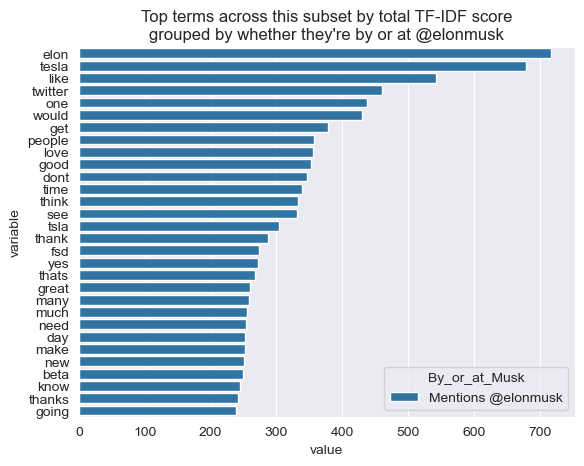

In [102]:
# these are also produced in the Rmarkdown notebook (index.Rmarkdown) in ggplot, which I prefer as a viz tool
tfidf_group = tfidf.groupby(['By_or_at_Musk']).agg(dict(zip(term_cols, len(term_cols)*['sum']))).reset_index().melt(id_vars=['By_or_at_Musk']).sort_values(['value', 'By_or_at_Musk'], ascending=False)
# tfidf_sum.head(30)
# tfidf_group.head(10)
n=30
plot_df = tfidf_group.head(n)

plt.title('Top terms across this subset by total TF-IDF score\ngrouped by whether they\'re by or at @elonmusk')
sns.barplot(x=plot_df.value, y=plot_df.variable, hue=plot_df.By_or_at_Musk);

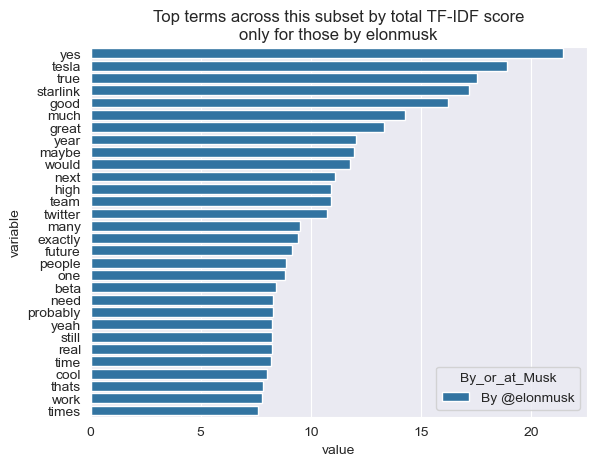

In [106]:
n=30
plot_df = tfidf_group.loc[tfidf_group.By_or_at_Musk == 'By @elonmusk'].head(n)
plot_df.to_csv('data/viz/tfidf_elon.csv')

plt.title(f'Top terms across this subset by total TF-IDF score\nonly for those by elonmusk')
sns.barplot(x=plot_df.value, y=plot_df.variable, hue=plot_df.By_or_at_Musk);

In [111]:
## let's take a subset of only a selection of terms for this period and then track how they do over time, as 
## temporary proxies for topics of the tweets
cols = ['ukraine', 'russia', 'tesla','space']

cols_subset = cols.copy()
cols_subset.extend(['datetime', 'By_or_at_Musk'])
em_terms = tfidf[cols_subset]
em_terms['datetime'] = pd.to_datetime(em_terms.datetime, errors = 'coerce',)
em_terms.dropna(subset=['datetime'], inplace=True)
time_df = em_terms.groupby([pd.Grouper(key='datetime', freq='D'), 'By_or_at_Musk']).agg(dict(zip(cols, len(cols)*['sum']))) #.reset_index().melt(id_vars=['By_or_at_Musk']).sort_values(['value', 'By_or_at_Musk'], ascending=False)
time_df = time_df.reset_index().melt(['datetime', 'By_or_at_Musk'])
# time_df = time_df.groupby(['datetime']).agg({'value':'max'})
# subselecting to take only those tweets since the start of June 
# this is different to the time filter applied to the model training data
# I've had to limit that data to be from August '22 onwards due to model fitting and computational constraints
time_df = time_df.loc[time_df.datetime>= pd.to_datetime('2022-06-01 00:00:00+00:00')]
time_df.to_csv('viz/tfidf_select_time.csv')
time_df.head()

,datetime,By_or_at_Musk,variable,value
804,2022-06-01 00:00:00+00:00,Mentions @elonmusk,ukraine,0.0
805,2022-06-02 00:00:00+00:00,Mentions @elonmusk,ukraine,0.0
806,2022-06-03 00:00:00+00:00,Mentions @elonmusk,ukraine,0.0
807,2022-06-04 00:00:00+00:00,Mentions @elonmusk,ukraine,0.0
808,2022-06-05 00:00:00+00:00,Mentions @elonmusk,ukraine,0.0


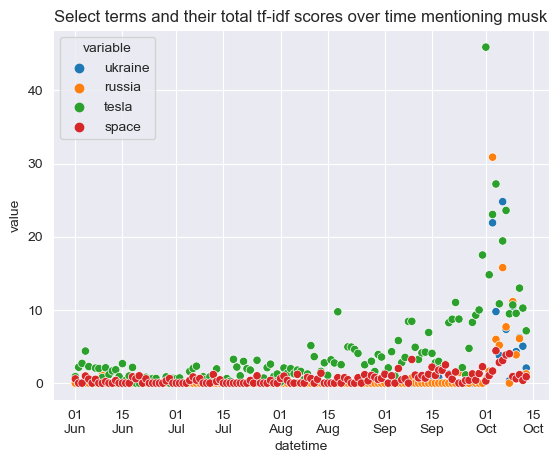

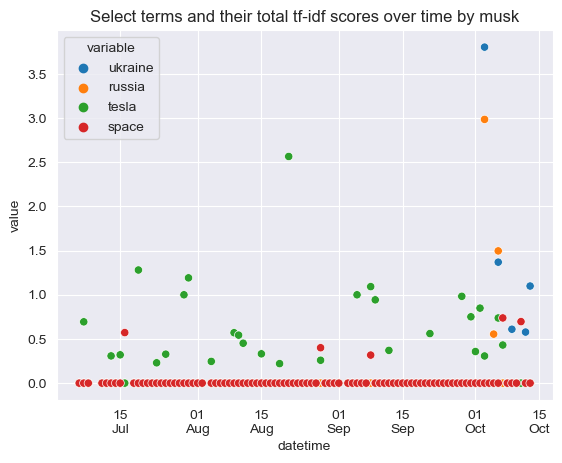

In [112]:
import matplotlib.dates as md

plt.title('Select terms and their total tf-idf scores over time mentioning musk')
plot = sns.scatterplot(data=time_df.loc[time_df.By_or_at_Musk=='Mentions @elonmusk'], x='datetime', y='value', hue='variable')
plot.xaxis.set_major_formatter(md.DateFormatter('%d\n%b'))
plt.show()

plt.title('Select terms and their total tf-idf scores over time by musk')
plot=sns.scatterplot(data=time_df.loc[time_df.By_or_at_Musk!='Mentions @elonmusk'], x='datetime', y='value', hue='variable')
plot.xaxis.set_major_formatter(md.DateFormatter('%d\n%b'))
plt.show()

It's quite understandable that the topic of the Ukraine and Russia has not been on Mr Musk's feed until relatively recently. However, it is noticeable that the term has spiked up so recently, dwarfing tesla and space. Unfortunately the tweet data available for Elon's own posts only goes back across 1000 of his tweets, so we're likely missing out on the tweets in the earlier part of the war where Starlink was deployed to Ukraine. 

In [109]:
#### how does tf-idf change over time
tfidf['datetime'] = pd.to_datetime(tfidf.datetime, errors = 'coerce',)
tfidf.dropna(subset=['datetime'], inplace=True)
time_df = tfidf.groupby([pd.Grouper(key='datetime', freq='D')]).agg(dict(zip(term_cols, len(term_cols)*['sum']))) #.reset_index().melt(id_vars=['By_or_at_Musk']).sort_values(['value', 'By_or_at_Musk'], ascending=False)
time_df = time_df.reset_index().melt('datetime')
time_df = time_df.groupby(['datetime']).agg({'value':'max'})

time_df.head()

,value
datetime,
2013-10-29 00:00:00+00:00,0.748748
2013-10-30 00:00:00+00:00,0.000000
2013-10-31 00:00:00+00:00,0.000000
2013-11-01 00:00:00+00:00,0.000000
2013-11-02 00:00:00+00:00,0.000000


<a id=bar><a/> 

## 3. Reducing dimensionality and visualising clusters
   
[LINK to table of contents](#contents)

In this section I'll load up the word vector data we have already generated using BERT's sentence models, reducing them via one of two techniques to lower dimensions, and then, along with the meta-data, performing some clustering:
- PCA - [Principal Component Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- UMAP - [Uniform Manifold Approximation and Projection](https://umap-learn.readthedocs.io/en/latest/parameters.html)

Note that I am doing this while the actual BERTopic cluster model is being generated on Google Colab. The results of this won't be as finished or tidy as those generated by BERTopic, but it's still interesting to explore, especially when taking the meta-data into account as well. Moreover, we'll be reducing to 2 dimensions in order to aid visualization at the expense of information, whereas the UMAP model being used for BERTopic will be reduced to only 5.

Inspiration for this part was taken partialy from [this blog post on visualising Twitter data](#https://towardsdatascience.com/visualizing-tweet-vectors-using-python-e528358bce68).

In [4]:
# tdf = pd.read_csv('data/clean/clean_text_and_metadata.csv', index_col='tweet_id').drop(columns =[x for x in tdf.columns if x.startswith('Unnamed:')])

tdf.head(2)

,datetime,display_name,tweet_text,User_id,#likes,#retweets,#responses,language,extracted_twitter_handles,extracted_URLs,extracted_hashtags,clean_tweet_text,Before_or_after_controversy,num_tokens,len_text
tweet_id,,,,,,,,,,,,,,,
1580601578310230016,2022-10-13 16:49:17+00:00,elonmusk,@JohnnaCrider1 Envy has driven him to madness,44196397.0,5344.0,292.0,448.0,en,['@JohnnaCrider1'],[],[],Envy has driven him to madness,After,6,30
1580600379074523136,2022-10-13 16:44:31+00:00,elonmusk,@leehumerian Starlink requires nothing except ...,44196397.0,643.0,74.0,78.0,en,['@leehumerian'],[],[],Starlink requires nothing except 50 Watt power...,After,21,143


In [5]:

path = 'data/wv/sentence_embeddings.pkl'
import pickle

with open(path, "rb") as f:
    wv = pickle.load(f)


In [6]:
sscale = StandardScaler()

In [8]:
wvdf= pd.DataFrame(data=wv['embeddings'],
                    index = wv['tweet_id'],
                    )
wvdf.index.name='tweet_id'
#now joining part of the metadata onto the wv df
full_df = tdf[[ '#likes','#retweets','#responses', 'num_tokens', 'len_text']] 

#we also need to scale the metadata vars we are including. The word vectors are each on a range from -1 to +1, so we will
#do the same, using standard scaler
feature_df = pd.DataFrame(data = sscale.fit_transform(full_df),index = full_df.index, columns = full_df.columns)

In [9]:
full_df = full_df.join(wvdf, how='right')
#checking our join went as expected
full_df.iloc[:, :6].info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 121222 entries, 1.553894180933759e+18 to nan
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   #likes      121220 non-null  float64
 1   #retweets   121220 non-null  float64
 2   #responses  121220 non-null  float64
 3   num_tokens  121220 non-null  float64
 4   len_text    121220 non-null  float64
 5   0           121222 non-null  float32
dtypes: float32(1), float64(5)
memory usage: 6.0 MB


In [10]:
# there are 2 rows missing from the metadata. This is data we can easily afford to drop 
full_df.dropna(subset=['len_text'], inplace=True)

In [11]:
#inst the UMAP algorithm
from umap import UMAP

RD_STATE=12345

umap_model_2d = UMAP(n_neighbors=15, n_components=2, 
                low_memory=False,
              min_dist=0.0, metric='cosine', random_state=RD_STATE)


In [12]:
umap_df_2d = umap_model_2d.fit_transform(full_df)
umap_df_2d = pd.DataFrame(umap_df_2d, columns = ['D1', 'D2'], index = full_df.index)
umap_df_2d.to_csv('data/preds/umap/cluster_2d_meta_wv.csv')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


After fitting our UMAP model, we now join the decomposed data with some of the meta-data we're interested in (e.g. the name of the tweeter, whether the tweet came before or after the controversial poll), and visualise our data points. 
It may be that we have lost too much information and that we should repeat but with greater number of components. 

In [30]:
meta = tdf[['Before_or_after_controversy', 'display_name', 'clean_tweet_text']] #.set_index('tweet_id')
meta['By_elonmusk'] = 'Not by @elonmusk'
meta.loc[meta.display_name=='elonmusk', 'By_elonmusk'] = 'By @elonmusk'
meta = meta.join(full_df, how='right')
meta.head(1)

umap_df_2d = umap_df_2d.join(meta, how='left')

In [31]:
meta.head(2)

,Before_or_after_controversy,display_name,clean_tweet_text,By_elonmusk,#likes,#retweets,#responses,num_tokens,len_text,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,...,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383
tweet_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.553894e+18,Before,wonderofscience,Watch the full video on Youtube,Not by @elonmusk,942.0,183.0,15.0,6.0,31.0,-0.021578,0.002904,0.003446,0.027498,0.046439,-0.049632,-0.014357,0.059617,-0.021093,-0.010988,0.051242,-0.000052,-0.071565,-0.072163,0.028322,-0.008717,-0.009105,-0.012655,-0.145497,-0.044573,0.042019,-0.074455,-0.006775,0.059667,-0.100538,0.092256,0.009757,0.076757,0.090434,-0.010599,-0.017293,...,0.049682,-0.006052,-0.082562,0.029517,-0.003512,-0.040969,-0.012301,0.007993,-0.055281,-0.075150,0.029581,0.007588,0.017338,0.029105,0.059634,0.027447,-0.068360,-0.068612,0.061011,0.031905,-0.060829,0.050152,-0.035889,-0.095805,-0.078557,0.056596,0.005326,-0.047145,0.038399,-0.008450,-0.025993,-0.014408,-0.022796,-0.009899,-0.041149,0.027621,0.028214,0.08509,0.034726,-0.000048
1.553895e+18,Before,sm,I dont know who needs to hear this but 1 lb of...,Not by @elonmusk,18.0,0.0,11.0,15.0,80.0,0.013303,-0.050172,0.014332,0.019889,-0.055969,-0.074003,-0.008961,-0.001368,0.066634,0.019080,0.007253,-0.092509,0.005797,-0.023097,-0.084881,-0.053987,0.106713,-0.000876,-0.073364,-0.048736,-0.001581,-0.035910,-0.008747,0.038963,-0.002391,-0.046120,-0.016976,-0.059001,-0.024755,-0.027552,0.006568,...,0.039171,-0.015831,-0.060744,0.043058,0.035039,-0.017001,0.046387,0.080140,-0.086667,-0.010731,0.057390,-0.032606,-0.014979,0.012986,0.019939,-0.014900,-0.112517,-0.002399,-0.009721,0.033383,-0.037019,0.027984,-0.116162,-0.019149,-0.011888,0.038197,-0.047155,0.033823,0.052567,0.025738,0.070256,0.002603,0.007837,-0.056977,-0.000725,-0.059882,0.004410,-0.02669,0.041441,0.043484


In [ ]:
import plotly.express as px


fig = px.scatter(umap_df_2d, 
              x='D1', y='D2', 
              color='By_elonmusk',
              hover_data= ['display_name', 
                          '#likes', 
                          '#retweets', 
                          '#responses',
                          'clean_tweet_text',
                          ],
              labels = {'D1':'D1', 
                        "D2":'D2'},
              title='UMAP representation of our data in 2 dimensions'
              )
plotly.offline.plot(fig, filename='fig/UMAP_cluster_2D.html')
# fig.show()

From what we can see, Elon's tweets are clearly clustered in one particular part of the data. Now, this could be as a result of the dimensions of the metadata (e.g. since we've encoded the number of responses and likes, and @elonmusk is a handle that generates a lot of both, we could easily just be seeing this manifest, as opposed to anything inherent to the tweet contents). 
However, when we look at the particular data points of Musk's that stretch out across D1 towards the centre, we'll notice that those few datapoints are particularly related to the war in Ukraine. We can zoom in and find the 5 data points furthest to the right are the following:

In [40]:
pd.set_option('max_colwidth', 800)
umap_df_2d.loc[umap_df_2d.By_elonmusk=='By @elonmusk'][['D1', 'clean_tweet_text']].sort_values('D1', ascending=False).head()

,D1,clean_tweet_text
tweet_id,,
1.576969e+18,0.642063,UkraineRussia Peace Redo elections of annexed regions under UN supervision Russia leaves if that is will of the people Crimea formally part of Russia as it has been since 1783 until Khrushchevs mistake Water supply to Crimea assured Ukraine remains neutral
1.576994e+18,0.449997,Lets try this then the will of the people who live in the Donbas Crimea should decide whether theyre part of Russia or Ukraine
1.576980e+18,0.193988,Indeed Biggest bot attack Ive ever seen
1.576999e+18,0.078367,Russia is doing partial mobilization They go to full war mobilization if Crimea is at risk Death on both sides will be devastatingRussia has 3 times population of Ukraine so victory for Ukraine is unlikely in total war If you care about the people of Ukraine seek peace
1.577839e+18,-0.571592,Below is the electoral map of 2012 Blue is the proRussia party


Ok, so there is something of a pattern here. Apart from the 3rd, the rest are obvioiusly connected. The fact that UMAP+sentence transformer were able to give this some distance is promising for our topic modelling. What about the tweets that are at the opposite end? 

In [41]:
umap_df_2d.loc[umap_df_2d.By_elonmusk=='By @elonmusk'][['D1', 'clean_tweet_text']].sort_values('D1', ascending=False).tail()

,D1,clean_tweet_text
tweet_id,,
1.572602e+18,-4.270615,Boys High was a good school but it was government not private Brooklyn would be considered a middle income not exclusive neighborhood in America
1.572604e+18,-4.453906,Although his methods of instruction very strongly favored stick over carrot I did learn a tremendous amount of engineering from him appreciation of art he is an extremely talented artist
1.580600e+18,-4.575978,Starlink requires nothing except 50 Watt power source With a small solar system plus battery or a generator you will have connectivity anywhere
1.572585e+18,-4.669950,Incorrect There was tuition for students from outside the school district which was a small part of the student body incl black students but not for students in district which I wasAlso I was there for 25 years previously attending govt schools for 9 of 12 years
1.580597e+18,-5.025326,Of course this happens almost every day They successfully destroyed Viasat in Ukraine several months ago


Hmm, less of a pattern here, except for perhaps those tweets mentioning school/education. We'll run into issues with the fact that UMAP was collapsed to only 2D. Let's take a look at 3D representation of the tweets:

In [35]:
umap_model_3d = UMAP(n_neighbors=15, n_components=3, 
                low_memory=False,
              min_dist=0.0, metric='cosine', random_state=RD_STATE)


umap_df_3d = pd.DataFrame(umap_model_3d.fit_transform(full_df), index = full_df.index, columns =['D1', 'D2', 'D3'] )
umap_df_3d = umap_df_3d.join(meta, how='left')

In [ ]:

fig = px.scatter_3d(
                umap_df_3d,
                x='D1', y='D2', z='D3',
              color= 'By_elonmusk',
              labels = {'D1':'D1', 
                        "D2":'D2',
                        'D3':'D3'
                        },
              hover_data= ['display_name', 
                          '#likes', 
                          '#retweets', 
                          '#responses',
                          'clean_tweet_text',
                          ],
              title='UMAP representation of our data in 3 dimensions'
              )

plotly.offline.plot(fig, filename='fig/UMAP_cluster_3D.html')
# fig.show()

Hmm, unfortunately this hasn't given us much greater clarify. Let's try again but with only Musk's Tweets. 

In [ ]:
umap_df_3d_musk = umap_df_3d.loc[umap_df_3d.By_elonmusk=='By @elonmusk']

fig = px.scatter_3d(
                umap_df_3d_musk,
                x='D1', y='D2', z='D3',
              color= 'By_elonmusk',
              labels = {'D1':'D1', 
                        "D2":'D2',
                        'D3':'D3'
                        },
              hover_data= ['display_name', 
                          '#likes', 
                          '#retweets', 
                          '#responses',
                          'clean_tweet_text',
                          ],
              title='UMAP representation of our data in 3 dimensions'
              )

plotly.offline.plot(fig, filename='fig/UMAP_cluster_3D_only_elonmusk.html')
# fig.show()

Ok, now we can start to pull the pieces apart a bit more. There is still the chance that the meta data is what is creating the groups in our data (i.e. what if D1 or D2 are just encoding the tweets that have more likes/responses/retweets?). Let's check the correlation between the 3 dimensions and those variables mentioned. 

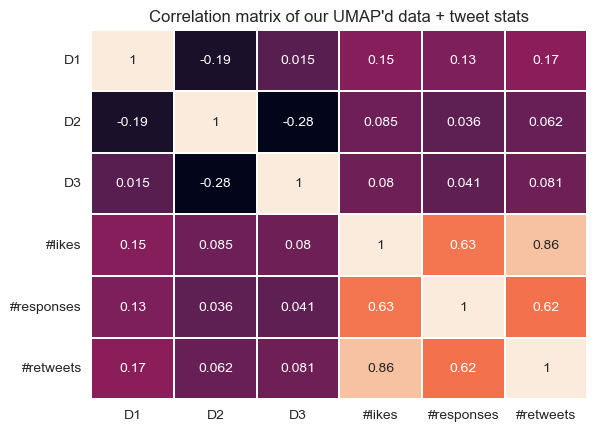

In [47]:
corr_check = umap_df_3d[['D1', 'D2', 'D3', '#likes', '#responses', '#retweets']].copy()

corr_mat = corr_check.corr()
plt.title('Correlation matrix of our UMAP\'d data + tweet stats')
sns.heatmap(corr_mat, annot=True, cbar=False, linewidth=0.01)
plt.savefig('fig/heatmap_corr_mat_UMAP_tweet_stats.png')

So it would appear that D1 encodes the most information about the tweet stats, but not a huge amount. I am satisfied that the tweet stats are not dominating the rest of the feature space in terms of importance.

With UMAP, we'd originally set the number of nearest neighbours to 15. Given that we have quite a large dataset (n=121220), I'm going to change this to a much higher value, namely 50. The online documentation for UMAP stated this param should be between 2 and 100. With no further guidance available, I am merely experimenting in the void here. I'll be going back down to 2D, since I don't think we gained that much from the extra dimension. 

In [49]:
umap_model_2d_n50 = UMAP(n_neighbors=50, n_components=2, 
                low_memory=False,
              min_dist=0.0, metric='cosine', random_state=RD_STATE)


umap_df_2d_n50 = pd.DataFrame(umap_model_2d_n50.fit_transform(full_df), index = full_df.index, columns =['D1', 'D2'] )
umap_df_2d_n50 = umap_df_2d_n50.join(meta, how='left')

In [ ]:

fig = px.scatter(umap_df_2d_n50, 
              x='D1', y='D2', 
              color='By_elonmusk',
              hover_data= ['display_name', 
                          '#likes', 
                          '#retweets', 
                          '#responses',
                          'clean_tweet_text',
                          ],
              labels = {'D1':'D1', 
                        "D2":'D2'},
              title='UMAP representation of our data in 2 dimensions\nwith nearest neighbours set to 50'
              )
plotly.offline.plot(fig, filename='fig/UMAP_cluster_2D_Neighbours50.html')
# fig.show()

Ok, so this has lost us some of the granularity we had previously, but Musk's war-related tweets are still quite distinguishable. It would be interesting to see what would happen if set nearest neighbours to a much higher value, e.g. 200. 

In [ ]:
umap_model_2d_n200 = UMAP(n_neighbors=200, n_components=2, 
                low_memory=False,
              min_dist=0.0, metric='cosine', random_state=RD_STATE)


umap_df_2d_n200 = pd.DataFrame(umap_model_2d_n200.fit_transform(full_df), index = full_df.index, columns =['D1', 'D2'] )
umap_df_2d_n200 = umap_df_2d_n200.join(meta, how='left')


fig = px.scatter(umap_df_2d_n200, 
              x='D1', y='D2', 
              color='By_elonmusk',
              hover_data= ['display_name', 
                          '#likes', 
                          '#retweets', 
                          '#responses',
                          'clean_tweet_text',
                          ],
              labels = {'D1':'D1', 
                        "D2":'D2'},
              title='UMAP representation of our data in 2 dimensions\nwith nearest neighbours set to 200'
              )
plotly.offline.plot(fig, filename='fig/UMAP_cluster_2D_Neighbours200.html')
# fig.show()

It would seem that we don't have any extra information imparted by changing this parameter. We will go forward with the original data encoded to 2 dims with 15 nearest neighbours. 

In [53]:
# umap_df_2d.to_csv('data/preds/umap/full_data_umap_2d_n15.csv')

<a id=one ><a/> 

## 4. Clustering with HDBSCAN
    
[LINK to table of contents](#contents)

To enable us to try and computationally detect groups of tweets, we'll use a clustering algorithm (namely HDBSCAN) to and sort our data into groups. 

1. Instantiate HDBSCAN and fit it to the selected UMAP'd data. 
2. Merge cluster results and visualise them in plotly_express. 
3. Tokenizer the tweet text check frequency distributions of particular words against the clusters. 

In [2]:
df = pd.read_csv('data/preds/umap/full_data_umap_2d_n15.csv', index_col='tweet_id')

In [14]:
data = df[['D1', 'D2']].copy()
data = data.values

In [38]:
min_cluster_size = 350
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size).fit(data)

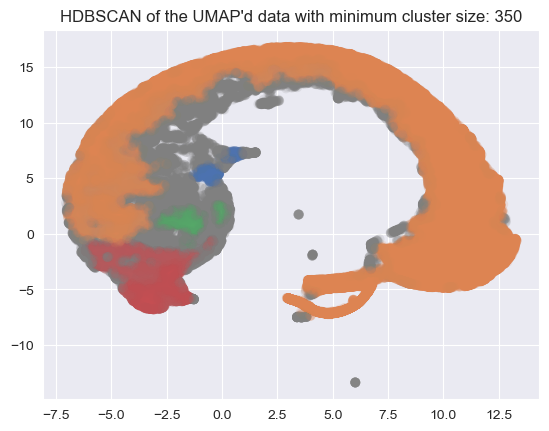

In [39]:
color_palette = sns.color_palette('deep', len(set(clusterer.labels_)))
cluster_colors = [color_palette[x] if (x >= 0 and x<=len(color_palette))
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.title(f'HDBSCAN of the UMAP\'d data with minimum cluster size: {min_cluster_size}')
plt.scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.15)

In [40]:
data[:, 0]

array([-1.1917655,  9.092584 , -4.2556796, ...,  8.285943 ,  4.9738326,
        5.8671665])

In [45]:
data_df = pd.DataFrame({'D1':data[:,0],'D2':data[:, 1],
                        'cluster':clusterer.labels_, 
                        'cluster_prob':clusterer.probabilities_
                             }, index = df.index)

data_df = data_df.join(df[['clean_tweet_text', '#likes', '#responses', '#retweets', 'display_name']])
data_df.tail()

,D1,D2,cluster,cluster_prob,clean_tweet_text,#likes,#responses,#retweets,display_name
tweet_id,,,,,,,,,
1.580617e+18,10.174480,-0.240514,1,1.0,The are happening for one reason and one reas...,9.0,0.0,3.0,JoeTalkShow
1.580617e+18,4.720883,-7.139556,1,1.0,Im fairly certain he said 20000 bottles have b...,0.0,0.0,0.0,MirrorinSpace
1.580617e+18,8.285943,-2.940801,1,1.0,Scottish rocket startup Skyrora fails on 1st s...,1.0,0.0,0.0,SPACEdotcom
1.580617e+18,4.973833,-7.124842,1,1.0,We should start a mental health fund for Dan O...,0.0,0.0,0.0,DBurkland
1.580617e+18,5.867166,-6.568638,1,1.0,In the Turing Trap paper I argue that augmenti...,0.0,0.0,0.0,erikbryn


In [46]:
data_df.cluster.nunique()

5

In [47]:
data_df.cluster_prob.value_counts()

1.000000    83879
0.000000    11917
0.889474      231
0.813575      198
0.932804      182
            ...  
0.955456        1
0.742771        1
0.932886        1
0.947914        1
0.807166        1
Name: cluster_prob, Length: 24004, dtype: int64

In [ ]:

fig = px.scatter(data_df, 
              x='D1', y='D2', 
              color='cluster',
              opacity = data_df['cluster_prob'].values,
              hover_data= ['display_name', 
                          '#likes', 
                          '#retweets', 
                          '#responses',
                          'clean_tweet_text',
                          ],
              labels = {'D1':'D1', 
                        "D2":'D2'},
              title='Clustered Twitter data (reduced via UMAP)'
              )
plotly.offline.plot(fig, filename='fig/hdbscan_umap_2d_c350.html')
# fig.show()

After some experimentation, it would appear that 350 is too large a number of datapoints for the minimal cluster size and that we need to scale down massively. Although I expect a lot of clusters to be noise, the 5 clusters generated are pretty useless at the moment and tell us nothing. I'll be setting the minimum cluster size to 50 instead.  

In [ ]:
min_cluster_size = 50
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size).fit(data)

data_df = pd.DataFrame({'D1':data[:,0],'D2':data[:, 1],
                        'cluster':clusterer.labels_, 
                        'cluster_prob':clusterer.probabilities_
                             }, index = df.index)

data_df = data_df.join(df[['clean_tweet_text', '#likes', '#responses', '#retweets', 'display_name']])

print(f'Number of clusters: {data_df.cluster.nunique()}.')

fig = px.scatter(data_df, 
              x='D1', y='D2', 
              color='cluster',
              opacity = data_df['cluster_prob'].values,
              hover_data= ['display_name', 
                          '#likes', 
                          '#retweets', 
                          '#responses',
                          'clean_tweet_text',
                          ],
              labels = {'D1':'D1', 
                        "D2":'D2'},
              title='Clustered Twitter data (reduced via UMAP)'
              )
plotly.offline.plot(fig, filename='fig/hdbscan_umap_2d_c50.html')
# fig.show()